# K-fold cross-validation test for WA

This notebook will allow the user to perform a K-fold cross validation test on your Watson Assistant workspace 

<div class="alert alert-block alert-info">
<b>Notebook Summary</b>
<br>
      
1. <b>Connect to WA</b> : credentials to connect to the right WA workspace<br>
2. <b>Scan the workspace</b> : download the GTs and intent labels of the entire workspace <br>
3. <b>Test and train split</b> : divide the dataset in test and train sets<br>
4. <b>Create k workspaces</b> : create k workspace and train it with the train-sets<br>
5. <b>Analyse k-fold results</b> : send the test set to the right workspace and analyse the results. 
</div>



## What is K-fold cross-validation test? 
The K-Fold Cross validation is any of various similar model validation techniques for assessing how the results of a statistical analysis will generalize to an independent data set. It is mainly used in settings where the goal is prediction, and one wants to estimate how accurately a predictive model will perform in practice. 


In k-fold cross-validation, the original sample is randomly partitioned into k equal sized subsamples. Of the k subsamples, a single subsample is retained as the validation data for testing the model, and the remaining k − 1 subsamples are used as training data. The cross-validation process is then repeated k times, with each of the k subsamples used exactly once as the validation data. 


<img src="images/cross validation 2.png" style="width: 300px;">

In this particular notebook we are going to use the stratified k-fold cross validation. This is a variation of KFold that returns stratified folds. The folds are made by preserving the percentage of samples for each class. It is used for unbalanced classes (e.g. intent dimensions that are not equals). 

## What K-fold means in Waston Assistant? 
Using any cross validation method in Watson Assistant will provide a more accurate measure of how well your virtual agent is performing. It is recommended to use the K-fold cross validation every time that we are modifying the workspace with substantial changes (e.g. creation of a new intent etc.)

## Libraries 

In [1]:
!pip install msgpack
!pip install watson-developer-cloud
import json 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# import seaborn as sns
from watson_developer_cloud import AssistantV1
from IPython.display import display
from sklearn.metrics import *
from sklearn.model_selection import *
import itertools

You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


## 1. Connect to Watson Assistant 


<div class="alert alert-block alert-warning">

<b>Data needed from the user</b>
<br>

    
1. <b>Credentials to connect to WA</b> : username, password, version and url (us-south, frankfurt etc)<br>
2. <b>Workspace</b> : the ID of the workspace that you want to analyse. <br>
3. <b>K-fold number</b>: usually the common used folds number is five. but in can be higher (e.g. 10) or less (i.e. 3) depending on the workspace size.<br>
4. <b>Threshold</b>: this is the minimum level of confidence level that you are expecting in order to check if the input text is triggering the right intent. For example, if the threshold = 0.40 and the input phrase is triggering the correct intent with only 35% of confidence level, we would want to count it as a False Positive (not meeting the required conditions) and not as a True Positive, despite the intent is correct. The default in WA is 0.2. Less than 20% the utterance is classified as `irrelevant`. However, if you need to have a higher threshold it can be set here. 
</div>

In [2]:
assistant = AssistantV1(
    username='',  #USER INPUT
    password='', #USER INPUT
    version='',  #USER INPUT
    url= '') #USER INPUT  
    # e.g. Frankfurt : 'https://gateway-fra.watsonplatform.net/assistant/api'

workspace = '' #USER INPUT

k_fold_number = 5 #USER INPUT 
threshold = 0.4   #USER INPUT 

### Let's test if everything is working correclty

In [3]:
response = assistant.message(workspace_id=workspace, input={'text': 'Hello!'}, 
                             alternate_intents= True)
dumps = json.dumps(response.get_result(), indent=2)
print(dumps)

data = json.loads(dumps)
intent= data['intents'][0]['intent']
confidence = data['intents'][0]['confidence']
print("intent detected: ", intent, "and the confidence level of the intent is :", confidence)
print('success')

{
  "intents": [
    {
      "intent": "General_Greetings",
      "confidence": 1
    },
    {
      "intent": "General_Negative_Feedback",
      "confidence": 0
    },
    {
      "intent": "General_Security_Assurance",
      "confidence": 0
    },
    {
      "intent": "location",
      "confidence": 0
    },
    {
      "intent": "pizza",
      "confidence": 0
    },
    {
      "intent": "Bot_Control_Approve_Response",
      "confidence": 0
    },
    {
      "intent": "Bot_Control_Reject_Response",
      "confidence": 0
    },
    {
      "intent": "General_About_You",
      "confidence": 0
    },
    {
      "intent": "Bot_Control_Unsure",
      "confidence": 0
    },
    {
      "intent": "turn-right",
      "confidence": 0
    }
  ],
  "entities": [],
  "input": {
    "text": "Hello!"
  },
  "output": {
    "generic": [
      {
        "response_type": "text",
        "text": "whatever"
      }
    ],
    "text": [
      "whatever"
    ],
    "nodes_visited": [
      "node_1_15

## 2. Scan the workspace 
There are two possible ways to do this: 
1. **Option 1** : Download the workspace in Json format and feed the file by using the cell starting with "## FROM JSON FILE" - the file needs to be in 'data' folder in the same directory of the notebook.   
2. **Option 2** : Scan the workspace by usign API calls and creating a dataframe - Use the script starting with "##API CALLS"


The complete Ground Truth of your workspace is representing the your whole dataset. It's your starting point. 
You should be able to create the dataframe named `df`. 

### Option 1 - from Json file 
You need to download the workspace in Json format. The reading process is faster than option 2. 

In [4]:
## FROM JSON FILE 

import json
from pprint import pprint

with open('./data/test_erika.json') as f: # USER INPUT - CHANGE THE FILE NAME HERE
    data = json.load(f)

def from_json(data):
    """
    retrieve the whole workspaces from json 
    """
    df2 = pd.DataFrame(columns = ['intent', 'text'])
    
    for i in range(len(data['intents'])):
        print("Scanned intent: {}".format(data['intents'][i]['intent']))
        for j in range(len(data['intents'][i]['examples'])):
            df2 = df2.append({'intent': data['intents'][i]['intent'],
                        'text': data['intents'][i]['examples'][j]['text']}
                       ,ignore_index=True)
    return df2 

df = from_json(data)

Scanned intent: Bot_Control_Confirm_Presence
Scanned intent: mission
Scanned intent: toppings
Scanned intent: location
Scanned intent: Bot_Control_Change_Subject
Scanned intent: Bot_Control_Unsure
Scanned intent: General_Agent_Capabilities
Scanned intent: Bot_Control_Standby
Scanned intent: Bot_Control_Ignore_Undo
Scanned intent: turn-right
Scanned intent: pizza
Scanned intent: General_Negative_Feedback
Scanned intent: General_Connect_to_Agent
Scanned intent: help
Scanned intent: General_Positive_Feedback
Scanned intent: General_Ending
Scanned intent: Bot_Control_Clarification
Scanned intent: General_Jokes
Scanned intent: General_About_You
Scanned intent: Bot_Control_Approve_Response
Scanned intent: General_Human_or_Bot
Scanned intent: Bot_Control_Reject_Response
Scanned intent: General_Greetings
Scanned intent: General_Security_Assurance
Scanned intent: Bot_Control_Start_Over


### Option 2 - using the API calls 
The reading process is slower than Option 1 but you can directly create the dataframe `df` without the need to download/upload any file.  

In [5]:
## API CALLS

intents = []
examples = []

def from_API():
    """
    the function will read the workspace via API and create the initial dataframe `df`
    """
    # Call WA to ge the list of the intents 
    response = assistant.list_intents(workspace_id = workspace, )
    obj = json.dumps(response.get_result(), indent=2)
    data = json.loads(obj)
    
    df = pd.DataFrame(columns = ['intent','text'])
    
    for i in range(len(data["intents"])): 
        name_intent = data["intents"][i]["intent"]

        # Call WA to get the list of Examples of each intent 
        response = assistant.list_examples(workspace_id = workspace, intent = name_intent)
        dumps = json.dumps(response.get_result(), indent=2)
        data_examples = json.loads(dumps)

        # get the Groud Truth (examples test) of each intent 
        for j in range(len(data_examples["examples"])): 
            text = data_examples["examples"][j]["text"]
            df = df.append({'intent':name_intent,'text': text},ignore_index=True)
        
        print ("Scanned intent: " , name_intent )
    
    return df 

df = from_API()

Scanned intent:  Bot_Control_Approve_Response
Scanned intent:  Bot_Control_Change_Subject
Scanned intent:  Bot_Control_Clarification
Scanned intent:  Bot_Control_Confirm_Presence
Scanned intent:  Bot_Control_Ignore_Undo
Scanned intent:  Bot_Control_Reject_Response
Scanned intent:  Bot_Control_Standby
Scanned intent:  Bot_Control_Start_Over
Scanned intent:  Bot_Control_Unsure
Scanned intent:  General_About_You
Scanned intent:  General_Agent_Capabilities
Scanned intent:  General_Connect_to_Agent
Scanned intent:  General_Ending
Scanned intent:  General_Greetings
Scanned intent:  General_Human_or_Bot
Scanned intent:  General_Jokes
Scanned intent:  General_Negative_Feedback
Scanned intent:  General_Positive_Feedback
Scanned intent:  General_Security_Assurance
Scanned intent:  help
Scanned intent:  location
Scanned intent:  mission
Scanned intent:  pizza
Scanned intent:  toppings
Scanned intent:  turn-right


In [6]:
# check how many utterances per intent you have - You should have at least 5 per intent 
df.groupby('intent').count()

,text
intent,
Bot_Control_Approve_Response,20
Bot_Control_Change_Subject,12
Bot_Control_Clarification,16
Bot_Control_Confirm_Presence,16
Bot_Control_Ignore_Undo,12
Bot_Control_Reject_Response,18
Bot_Control_Standby,20
Bot_Control_Start_Over,20
Bot_Control_Unsure,12


## 3. Train and Test Split
We are going to use the [Stratified k-fold split](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html)

The reason is that we want to make sure that each intent dimension is represented correctly in each train sets. 

Each fold needs to contain a test and a train set. The peculiarity of the k-fold is that the train sets will not overlap. Therefore it's important to keep track of each fold because they will be then used to create the k workspace in WA. 

In [7]:
def create_folds(df):
    """
    create the folds for the k-fold test. It is using the Stratifies K-fold division. 
    
    :param df: the dataframe containing the whole GT of the workspace 
    :return folds: a list of folds containing for each fold the train and test set indexes. 
    """
    folds = []
    i = 0
    skf = StratifiedKFold(n_splits = k_fold_number, shuffle = True, random_state = 2)
    for train_index, test_index in skf.split(df['text'], df['intent']):
        fold = {"train": train_index,
                "test": test_index}
        folds.append(fold)
        print("fold num {}: train set: {}, test set: {}".format(i+1,len(folds[i]["train"]), len(folds[i]["test"])))
        i += 1
    
    return folds

## 4. Create k workspaces: 
We want to use the folds generated previously to create the new k workspaces. 

In [8]:
def count_workspaces():
    """
    counting the existing workspaces and check if there are spaces for the k-workspace 
    """
    response = assistant.list_workspaces().get_result()
    
    if(len(response['workspaces'])+k_fold_number <=20):
        print("You have space to perform the k-fold test")
    else: 
        remove = len(response['workspaces'])+k_fold_number-20
        print("Be careful! The K-fold test will make you exceed the 20 workspace limit.")
        print("Make sure to remove {} workspaces before creating the k-fold workspaces".format(remove))
    return 

count_workspaces()

You have space to perform the k-fold test


In order to limit the amount of API calls during this process we would like to create all the intents and utterances in the same moment that we are creating the workspace. 

In [9]:
def create_intents(train_index):
    """
    It collects the intents in json format to send when creating the workspace 
        
    :param train_index: that are the results of the 'create_folds' function
    :return intent_results: if a list of dictionaries that will be sent when new workspace will be created
    """
    
    intent_results = []
    for i in train_index:
        row = {}
        text = df.iloc[i]['text']
        intent = df.iloc[i]['intent']

        if not any(d['intent'] == intent for d in intent_results):
            row = { 'intent': intent, 
                    'examples': [ {'text': text } ] } 
        else:
            row = [d for d in intent_results if d.get('intent') == intent][0]
            intent_results[:] = [d for d in intent_results if d.get('intent') != intent]
            e = {'text': text}
            row['examples'].append(e)

        intent_results.append(row)
    
    return intent_results




def create_workspace(intents_json, fold_number):
    """
    create one workspace 
    
    :param intent_json : output of the 'create_intents' function
    :param fold_number: the number of the fold  
    :return workspace_id: the id of the workspace that has been generated
    """
    response = assistant.create_workspace(
        name='K_FOLD test {}'.format(fold_number+1),
        description='workspace created via API k-fold', 
        intents = intents_json
    ).get_result()
    
    workspace_id = response.get('workspace_id')
    
    return workspace_id




def create_kfold_WA(folds):
    """
    create the k-fold workspaces in WA
    
    :param folds: are the folds created in the function `create_folds`
    :return workspaces: is a list of workspaces ID generated 
    """
    workspaces = []
    for i in range(len(folds)):
        print("creating K-FOLD workspace {} out of {}".format(i+1, len(folds)))
        train = folds[i]["train"]
        intents = create_intents(train)
        workspace_id = create_workspace(intents, i)
        workspaces.append(workspace_id)
    
    return workspaces

folds = create_folds(df)
workspaces = create_kfold_WA(folds)

fold num 1: train set: 330, test set: 94
fold num 2: train set: 335, test set: 89
fold num 3: train set: 342, test set: 82
fold num 4: train set: 344, test set: 80
fold num 5: train set: 345, test set: 79
creating K-FOLD workspace 1 out of 5
creating K-FOLD workspace 2 out of 5
creating K-FOLD workspace 3 out of 5
creating K-FOLD workspace 4 out of 5
creating K-FOLD workspace 5 out of 5


### Check the status 
Before performing any test, we need to make sure that the workspaces have finished the training 

In [11]:
def check_status(workspaces): 
    """
    check the status of the workspace just created - You can start the k-fold only when 
    the workspaces are `Available` and not in Training mode. 
    """
    for i in range(len(workspaces)):
        response = assistant.get_workspace(workspace_id = workspaces[i]).get_result()
        status = response['status']
        print("Fold number:{} ({}), Workspace is {}".format(i+1,workspaces[i], status))
        # The status can be: unavailable, training, non-existent, failed 
        if (status != 'Available'):
            print("The workspace is not available - check the details")
    return 

check_status(workspaces)

Fold number:1 (b1c29762-b3b5-4cc6-9a11-fb2896e2344a), Workspace is Available
Fold number:2 (4245c07b-e6c2-4ef0-87ed-bb8709e48b5d), Workspace is Available
Fold number:3 (d2b82e93-ffc5-43ca-8a8b-13186dfdb61c), Workspace is Available
Fold number:4 (35ed229f-b15f-40b2-b945-2d80d765ab18), Workspace is Available
Fold number:5 (fc7923bd-8fc4-41a6-a49e-0d507c45299c), Workspace is Available


In [13]:
def test_kfold(df_test, ws_id):
    """
    This function will take the regression test uploaded in csv and will send each phrase to WA and collect 
    information on how the system responded. 
    
    :param df_test: the dataframe containing the testing phrases 
    :param ws-id: the index of the fold that would be used to call the correct workspace id that needs to be test 
    :return results: a pandas dataframe with original text, predicted intent and also the results from WA
    """
    results = pd.DataFrame([],columns = ['original_text','predicted_intent','actual_intent1',
                           'actual_confidence1','actual_intent2','actual_confidence2','actual_intent3',
                           'actual_confidence3'])

    for i in range(len(df_test)):

        text = df_test['text'][i]

        response = assistant.message(workspace_id=workspaces[ws_id], input={'text': text}, alternate_intents= True)
        dumps = json.dumps(response.get_result(), indent=2)
        print(text)

        data = json.loads(dumps)

        intent1= data['intents'][0]['intent']
        intent2= data['intents'][1]['intent']
        intent3= data['intents'][2]['intent']
        confidence1 = data['intents'][0]['confidence']
        confidence2 = data['intents'][1]['confidence']
        confidence3 = data['intents'][2]['confidence']

        results = results.append({
                'original_text': df_test["text"][i],
                'predicted_intent': df_test["intent"][i],
                'actual_intent1': intent1, 
                'actual_confidence1':confidence1, 
                'actual_intent2':intent2, 
                'actual_confidence2': confidence2, 
                'actual_intent3': intent3,
                'actual_confidence3': confidence3, 
            }, ignore_index=True)
        
    results.to_csv("./results/kfold_{}_raw.csv".format(ws_id+1), encoding='utf-8')
    
    return results



def run_kfold_test(folds):
    """
    run the k-fold test. It is going to take folds as input and it will send the test dataframes to the right
    workspaces. 
    
    :param folds: output list from the function `create_folds`
    :return test_results: is list of results (dataframes) for each fold.  
    """
    test_results = []
    for i in range(len(folds)):
        print("===================================================")
        print("RUNNING K-FOLD FOR FOLD NUMBER {}".format(i+1))
        test_index = folds[i]['test']
        df_test = df.iloc[test_index]
        df_test_reindexed = df_test.reset_index()
        results = test_kfold(df_test_reindexed, i)
        test_results.append(results)
    
    print("FINISHED")
        
    return test_results

results_kfold = run_kfold_test(folds)

RUNNING K-FOLD FOR FOLD NUMBER 1
Affirmative. That's what I'm looking for.
Got it
That is the proper response.
Yes
Chat about something else
Discuss something else
Let us change the topic
Can you say that again please?
I didn't catch that
I didn't quite understand what you said
What are you saying?
Am I talking to someone?
Are you still around?
Are you still here with me?
Is anybody home?
I didn't mean to do that actually, let's go back
It's not what I mean
Nothing
Bad response
It is not what I want
That answer is incorrect
You didn't understand me
Back again soon
Can you wait for me?
I would like to put you on hold
Out for a break
Actually, let's start over
Can we please start over?
One more time from the beginning
We need a do-over
I haven't got a clue
I m not certain I get what you re saying
No idea
About you
Do you know who you are?
Tell me something about yourself
Who are you?
Can you please give me a list of the types of things you can help me with?
Can you tell me what services 

Sure thing!
That is what I need
This is alright
You read my mind
I have one more question
Talk about something else
I don't understand what you're saying
What are you talking about?
What do you mean by that?
Did you hear what I said?
Speak to me if you are there.
You around?
Never mind
Wait! Let's back up few steps and do that again
Not the right response
Wrong response
You did not understand what I said
Hold on
Just a sec
Keep holding
Wait
I would like to start all over
Please initiate from the beginning
Please start a new chat
We will need to begin again
No clue
You got me
Introduce your self
What languages do you speak?
What's your name?
Why are you here?
How can you solve my problems?
I do not know what to ask
Tell me about what kind of things you do?
What are my options?
What are you used for?
Where can I find the frequently asked questions?
Call agent
Can I speak with somebody?
Can I talk to someone?
Connect me to a live operator please.
Do not want a robot?
I don't want to talk 

--------------

## 5. Analyse the results 
Once we have the results for each fold, it's time to analyse the results. Let's prepare the data. 



In [14]:
def data_prep(dataframe):
    """
    this function prepares the dataframe. We are adding a new column called "actual_intent_correct" 
    if the intent1 is triggered with less than x% of confidence level (determined in `threshold`) then 
    the value will be put to zero.
    
    :param dataframe: it is the dataframe to wrangle 
    """
    
    dataframe["actual_intent_correct"] = dataframe["actual_intent1"]
    dataframe["actual_intent_correct"] = np.where((dataframe["actual_confidence1"]<threshold),\
                                                  "BELOW_THRESHOLD", dataframe["actual_intent1"])
    return dataframe

### Collection of Metrics

      
1. **Accuracy** : In multilabel classification, this function computes subset accuracy, the set of labels predicted for a sample must exactly match the corresponding set of labels in _y_true_.
2. **Precision** : The precision is the ratio _tp / (tp + fp)_ where tp is the number of _true positives_ and fp the number of _false positives_. The precision is intuitively the ability of the classifier not to label as positive a sample that is actually negative.
3. **Recall** : The recall is the ratio _tp / (tp + fn)_ where tp is the number of _true positives_ and fn the number of _false negatives_. The recall is intuitively the ability of the classifier to find all positive samples. 
4. **F-score** : The F-beta score can be interpreted as a weighted harmonic mean of the precision and recall, where an F-beta score reaches its best value at 1 and worst score at 0. The F-beta score weighs recall more than precision by a factor of beta. A value of beta == 1.0 means recall and precision are equally important.

[precision_recall_fscore_support function](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html#sklearn.metrics.precision_recall_fscore_support)


In [15]:
def define_metrics(results_kfold):
    """
    define the metrics of the k-fold
    
    :param results_kfold: is the list of results coming from `run_kfold_test` function
    :return result_table: is the dataframe containing the metrics for each fold. 
    """
    result_table = pd.DataFrame([],columns=["fold","total_tested","incorrect","accuracy", "precision","recall","fscore"])

    for i in range(len(results_kfold)):
        data = data_prep(results_kfold[i])
        incorrect_n = data.loc[data['actual_intent_correct']!=data["predicted_intent"]]
        incorrect_avg_conf = incorrect_n['actual_confidence1'].mean()
        precision,recall,fscore,support=precision_recall_fscore_support(data["actual_intent_correct"],data["predicted_intent"],average='weighted')
        accuracy = accuracy_score(data["actual_intent_correct"], data["predicted_intent"])
        result_table = result_table.append({
            "fold": i+1,
            "total_tested": len(results_kfold[i]),
            "incorrect": len(incorrect_n),
            "incorrect_avg_confidence": incorrect_avg_conf,
            "accuracy": accuracy, 
            "precision": precision, 
            "recall": recall, 
            "fscore": fscore
        }, ignore_index=True)
    
    return result_table

result_table = define_metrics(results_kfold)
result_table

/Users/erikaagostinelli/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/erikaagostinelli/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


,fold,total_tested,incorrect,accuracy,precision,recall,fscore,incorrect_avg_confidence
0,1.0,94.0,25.0,0.734043,0.732333,0.734043,0.713158,0.485669
1,2.0,89.0,26.0,0.707865,0.703184,0.707865,0.689214,0.569316
2,3.0,82.0,28.0,0.658537,0.682085,0.658537,0.663745,0.580916
3,4.0,80.0,25.0,0.687500,0.723065,0.687500,0.695538,0.582701
4,5.0,79.0,23.0,0.708861,0.702140,0.708861,0.687003,0.538915


<img src="images/precision-recall-relevant-selected.jpg" style="width: 500px;">

Confusion matrix for the Intent matching


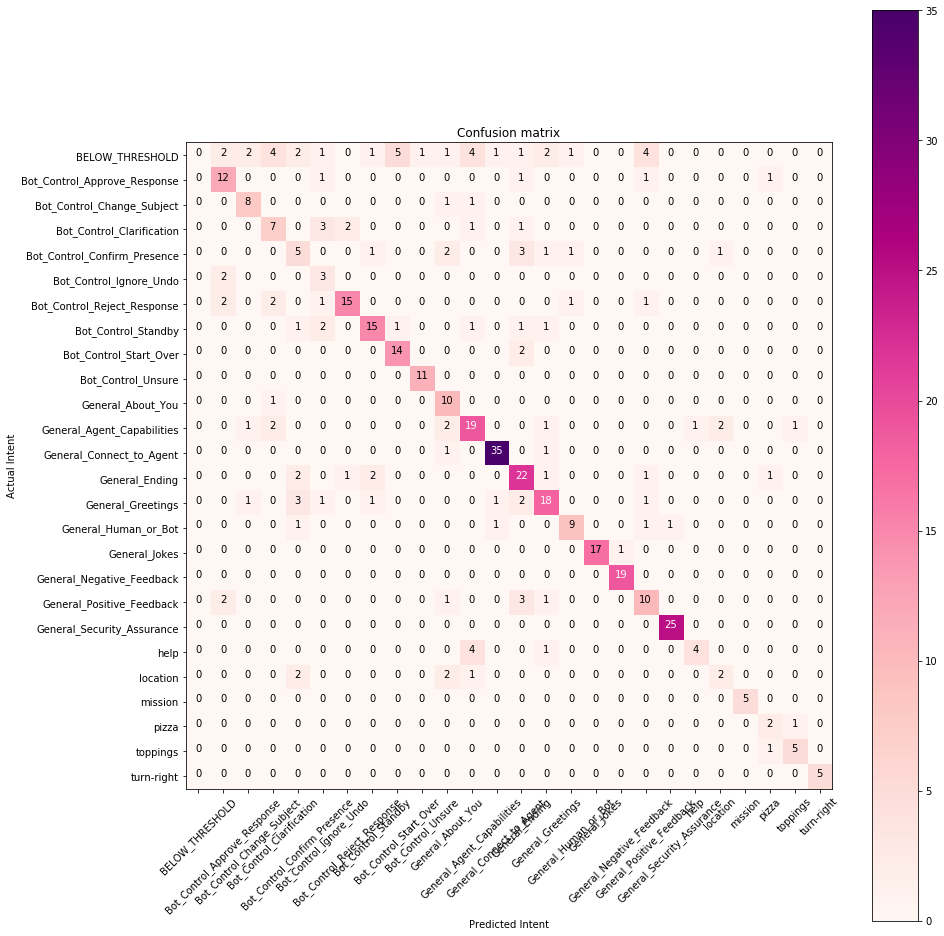

In [16]:
def data_prep_confusion_matrix(list_df):
    """
    this function prepares the dataframe to be then used for the confusion matrix 
    
    :param list_df: is the list of dataframes (results) coming from each fold. 
    :return matrix: it is the confusion matrix that will be displayed in `plot_confusion_matrix`
    :return lab: the lables that are used for the visualisation 
    """
    df = pd.concat(list_df) 
    dataframe = df.reset_index()
    
    dataframe["actual_intent_correct"] = dataframe["actual_intent1"]
    dataframe["actual_intent_correct"] = np.where((dataframe["actual_confidence1"]<threshold),\
                                                  "BELOW_THRESHOLD", dataframe["actual_intent1"])
    matrix = confusion_matrix(dataframe["actual_intent_correct"], dataframe["predicted_intent"])
    
    lab1 = dataframe["actual_intent_correct"].unique()
    lab2 = dataframe["predicted_intent"].unique()
    lab = np.union1d(lab1,lab2)
    
    return matrix, lab, dataframe

matrix, lab, combined_df  = data_prep_confusion_matrix(results_kfold)



def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.RdPu):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix for the Intent matching")
    else:
        print('Confusion matrix for the Intent matching')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Actual Intent')
    plt.xlabel('Predicted Intent')
    plt.tight_layout()
    
    return 
    
plt.figure(figsize=(14,14))
plot_confusion_matrix(matrix, classes=lab,
                      title='Confusion matrix')

In [17]:
accuracy = accuracy_score(combined_df["actual_intent_correct"], combined_df["predicted_intent"])
print("Accuracy:", accuracy)
precision,recall,fscore,support=precision_recall_fscore_support(combined_df["actual_intent_correct"],
                                                                combined_df["predicted_intent"],
                                                                average='weighted')
print("Precision:", precision)
print("Recall:", recall)
print("FScore:", fscore)
print(classification_report(combined_df["actual_intent_correct"], combined_df["predicted_intent"]))

Accuracy: 0.7004716981132075
Precision: 0.6668821190928538
Recall: 0.7004716981132075
FScore: 0.6776249393581507
                              precision    recall  f1-score   support

             BELOW_THRESHOLD       0.00      0.00      0.00        32
Bot_Control_Approve_Response       0.60      0.75      0.67        16
  Bot_Control_Change_Subject       0.67      0.80      0.73        10
   Bot_Control_Clarification       0.44      0.50      0.47        14
Bot_Control_Confirm_Presence       0.31      0.36      0.33        14
     Bot_Control_Ignore_Undo       0.25      0.60      0.35         5
 Bot_Control_Reject_Response       0.83      0.68      0.75        22
         Bot_Control_Standby       0.75      0.68      0.71        22
      Bot_Control_Start_Over       0.70      0.88      0.78        16
          Bot_Control_Unsure       0.92      1.00      0.96        11
           General_About_You       0.50      0.91      0.65        11
  General_Agent_Capabilities       0.61      0

/Users/erikaagostinelli/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Delete the workspace 
Once you have finished your testing and you have the results, you can delete the workspaces. 

In [18]:
def detele_kfold_workspaces(workspaces):
    """
    delete the workspaces when you dont need them anymore
    """
    for i in range(len(workspaces)):
        print("deleting workspace {} out of {}: {}".format(i+1, len(workspaces), workspaces[i]))
        response = assistant.delete_workspace(
                workspace_id = workspaces[i]).get_result()
    return 

detele_kfold_workspaces(workspaces)

deleting workspace 1 out of 5: b1c29762-b3b5-4cc6-9a11-fb2896e2344a
deleting workspace 2 out of 5: 4245c07b-e6c2-4ef0-87ed-bb8709e48b5d
deleting workspace 3 out of 5: d2b82e93-ffc5-43ca-8a8b-13186dfdb61c
deleting workspace 4 out of 5: 35ed229f-b15f-40b2-b945-2d80d765ab18
deleting workspace 5 out of 5: fc7923bd-8fc4-41a6-a49e-0d507c45299c


## Improvement List



1. export to CSV - what and which table? 
2. pie / donut chart to show which intents are the overlapping the most. 

Author: [Erika Agostinelli](https://www.linkedin.com/in/erikaagostinelli/)